# Module 8 : Classifying Iris with Neural Networks

In this session, you will create a Multilayer Perceptron (MLP) model to practice on the Iris dataset, to get more familiarized with PyTorch.



#### Some initial library loading!

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import os, sys
import itertools
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale, LabelEncoder, StandardScaler, Normalizer, MinMaxScaler
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from scipy import stats

import torch
from torch import nn
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
import tqdm

# Random seed for numpy
np.random.seed(18937)

#### Loading the Data Set

In [2]:
from sklearn import datasets

iris = datasets.load_iris()
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [3]:
# Features in this dataset
print('features', iris.feature_names)

# Target classes of this 3-class prediction problem.
print('targets', iris.target_names)

features ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
targets ['setosa' 'versicolor' 'virginica']


In [4]:
df = pd.DataFrame(iris.data, columns = iris.feature_names)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


#### Task 1: Assign features and the target to variables X and y

In [5]:
# Add code below this comment  (Question #P01)
# ----------------------------------

X = iris.data
y = iris.target



## Do a little more inspection

Is `X` a pandas dataframe or a numpy array? What kind of data does it contain? Let's run some descriptive statistics.

In [6]:
print('type', type(X))
print('shape', X.shape)
df.describe()

type <class 'numpy.ndarray'>
shape (150, 4)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [7]:
# Prettify to make that more readable.

for stat, val in stats.describe(X)._asdict().items():
    if stat!='minmax':
        print('{:<10}: {}'.format(stat, val))
    else:
        print('{:<10}: {}'.format('min', val[0]))
        print('{:<10}: {}'.format('max', val[1]))

nobs      : 150
min       : [4.3 2.  1.  0.1]
max       : [7.9 4.4 6.9 2.5]
mean      : [5.84333333 3.05733333 3.758      1.19933333]
variance  : [0.68569351 0.18997942 3.11627785 0.58100626]
skewness  : [ 0.31175306  0.31576711 -0.27212767 -0.10193421]
kurtosis  : [-0.57356795  0.18097632 -1.39553589 -1.33606741]


In [8]:
from collections import Counter
print('type: ', type(y))
print('shape: ', y.shape)
print(Counter(y))

type:  <class 'numpy.ndarray'>
shape:  (150,)
Counter({0: 50, 1: 50, 2: 50})


# Visualize the Data 

We see above that the data features are 4-D.
Generate two visualizations of the data using Red, Blue, Green for the colors of
`setosa`, `versicolor`, `virginica`, respectively.

#### Task 2: First, visualize along dimensions 0,1.


([], <a list of 0 Text yticklabel objects>)

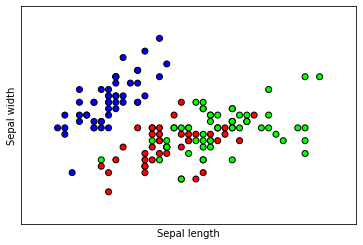

In [9]:
# Add code below this comment  (Question #P02)
# ----------------------------------

#'sepal length (cm)', 'sepal width (cm)'

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="brg",
            edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())



#### Task 3: Second, visualize along dimensions 2,3

([], <a list of 0 Text yticklabel objects>)

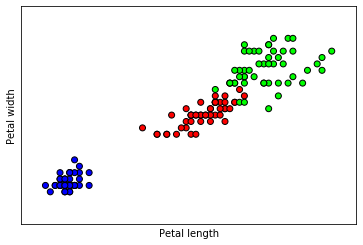

In [10]:
# Add code below this comment  (Question #P03)
# ----------------------------------

# 'petal length (cm)', 'petal width (cm)'


x_min, x_max = X[:, 2].min() - .5, X[:, 2].max() + .5
y_min, y_max = X[:, 3].min() - .5, X[:, 3].max() + .5

# Plot the training points
plt.scatter(X[:, 2], X[:, 3], c=y, cmap="brg",
            edgecolor='k')
plt.xlabel('Petal length')
plt.ylabel('Petal width')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())


### Build am NN model

#### Task 4: Define the neural architecture with PyTorch with the following config

1. A hidden layer with 4 neurons
2. Use sigmoid activation fuction for the hidden layer
3. Convert the output layer values to probabilities


In [11]:
class MyModel(nn.Module):
    def __init__(self, D_in, H, D_out):
        """
        D_in: number of input
        """
        super(MyModel, self).__init__()
        self.layer1 = nn.Linear(D_in, H) # input to hidden layer
        self.layer2 = nn.Linear(H, D_out) # hidden layer to output layer
        
    def forward(self, x):
        h_pred = torch.sigmoid(self.layer1(x)) # activation function after the first hidden layer. Change it to nn.ReLU to see the difference     
        y_pred = torch.softmax(self.layer2(h_pred), dim=1) # softmax function: converts numbers to probabilities 
        return y_pred



In [12]:
model = MyModel(X.shape[1], 4, 3)

In [13]:
!pip install torchsummary

In [14]:
from torchsummary import summary
summary(model, (X.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 4]              20
            Linear-2                    [-1, 3]              15
Total params: 35
Trainable params: 35
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


#### Task 5

Compile the model with the `Cross Entropy` loss function and `rmsprop` optimizer.
 
 

In [15]:
# Add code below this comment  (Question #P05)
# ----------------------------------

loss = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.001)  


### Divide the Data into Train and Test splits

To make this this more fun, we are going to use a 70%/30% split on the training and testing data.

#### Task 6: Prepare the data for training the model.

In [16]:
# Add code below this comment  (Question #P06)
# ----------------------------------

# scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(iris.data)

# train/test split 

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)

# convert train/test to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
X_test_tensor = torch.tensor(X_test, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).view(-1, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).view(-1, 1)

# convert y to one hot encoding: not required if we use cross entropy
# y_train_one_hot = nn.functional.one_hot(y_train_tensor)
# y_test_one_hot = nn.functional.one_hot(y_test_tensor)


In [17]:
BATCH_SIZE = 1  # it is possible to feed more than one istances to the model. 
# These set of instances is called batch. For simplicity, let's keep one instance per batch

train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

### Task 7: Train the model on the train data

Choose an appropriate number of epochs and batch size.


In [18]:
# Add code below this comment  (Question #P07)
# ----------------------------------

N_EPOCHS = 100  # In each epoch, the model iterate over all the instances 

for epoch in range(N_EPOCHS):
    epoch_loss = 0
    epoch_acc = 0
    for x, y in train_loader:
        y_pred = model(x)      # Forward pass: get the network output for this instance
        l = loss(y_pred, y.view(-1))    # estimate error for this instance
        epoch_loss += l.item() # Aggregate error
        
        optimizer.zero_grad()  # As backward method accumulates gradient, we need to set it to 0
        l.backward()           # Backward pass: Estimate gradient 
        optimizer.step()
        
        correct = (torch.argmax(y_pred, dim=1) == y).type(torch.FloatTensor)
        epoch_acc += correct.item()

    if (epoch%5)==0:
        print(f'Epoch {epoch+0:03}: | Total Loss: {epoch_loss:.5f} | \
Avg Loss: {epoch_loss/len(train_loader):.5f} | Training Acc: {epoch_acc/len(train_loader):.2f}')

Epoch 000: | Total Loss: 117.09764 | Avg Loss: 1.11522 | Training Acc: 0.23
Epoch 005: | Total Loss: 113.25608 | Avg Loss: 1.07863 | Training Acc: 0.50
Epoch 010: | Total Loss: 108.31080 | Avg Loss: 1.03153 | Training Acc: 0.39
Epoch 015: | Total Loss: 100.71837 | Avg Loss: 0.95922 | Training Acc: 0.68
Epoch 020: | Total Loss: 93.08760 | Avg Loss: 0.88655 | Training Acc: 0.70
Epoch 025: | Total Loss: 88.39792 | Avg Loss: 0.84188 | Training Acc: 0.80
Epoch 030: | Total Loss: 85.46069 | Avg Loss: 0.81391 | Training Acc: 0.84
Epoch 035: | Total Loss: 83.16507 | Avg Loss: 0.79205 | Training Acc: 0.88
Epoch 040: | Total Loss: 81.05270 | Avg Loss: 0.77193 | Training Acc: 0.91
Epoch 045: | Total Loss: 78.99562 | Avg Loss: 0.75234 | Training Acc: 0.92
Epoch 050: | Total Loss: 76.98360 | Avg Loss: 0.73318 | Training Acc: 0.93
Epoch 055: | Total Loss: 75.10539 | Avg Loss: 0.71529 | Training Acc: 0.94
Epoch 060: | Total Loss: 73.36408 | Avg Loss: 0.69871 | Training Acc: 0.96
Epoch 065: | Total Lo

----

### Task 8: Evaluate your trained model on the on the test data

Print the loss and accuracy obtained using model.evaluate(...).

In [19]:
# Add code below this comment  (Question #P08)
# ----------------------------------

model.eval()

with torch.no_grad():
    y_pred = model(X_test_tensor)


### Task 9: Interpret the classifier output

Run the cell below, then provide your interpretation of the output in the cell below that.  


In [20]:
print(y_pred.shape)
print(y_pred)

torch.Size([45, 3])
tensor([[1.1085e-05, 6.7057e-02, 9.3293e-01],
        [3.1696e-03, 8.3932e-01, 1.5751e-01],
        [6.0589e-02, 9.3490e-01, 4.5118e-03],
        [9.8181e-01, 1.8180e-02, 4.7206e-06],
        [2.6562e-04, 3.6501e-01, 6.3472e-01],
        [5.4478e-06, 4.5046e-02, 9.5495e-01],
        [9.8231e-01, 1.7689e-02, 4.5130e-06],
        [2.1461e-02, 9.5863e-01, 1.9910e-02],
        [6.8185e-03, 9.2712e-01, 6.6060e-02],
        [9.8217e-01, 1.7828e-02, 4.5697e-06],
        [9.8243e-01, 1.7563e-02, 4.4418e-06],
        [9.8213e-01, 1.7870e-02, 4.5940e-06],
        [9.8219e-01, 1.7803e-02, 4.5680e-06],
        [3.5886e-02, 9.5523e-01, 8.8849e-03],
        [9.8191e-01, 1.8086e-02, 4.6618e-06],
        [9.8137e-01, 1.8628e-02, 4.9296e-06],
        [2.7197e-04, 3.3532e-01, 6.6441e-01],
        [3.4543e-03, 8.1026e-01, 1.8628e-01],
        [3.4209e-03, 8.4509e-01, 1.5149e-01],
        [9.8183e-01, 1.8166e-02, 4.7167e-06],
        [2.6565e-05, 1.0683e-01, 8.9314e-01],
        [1.206

### Task 10: Print the predicted Class Label, then generate a confusion matrix and flassification report
 * Review the documentation: https://docs.scipy.org/doc/numpy/reference/generated/numpy.argmax.html

In [21]:
# Fix code below this comment  (Question #P10)
# ----------------------------------

from sklearn.metrics import classification_report, confusion_matrix

pred_class = np.argmax(y_pred, axis=1)
print(pred_class)



print(confusion_matrix(y_test, pred_class))
print(classification_report(y_test, pred_class))

tensor([2, 1, 1, 0, 2, 2, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 2, 1, 1, 0, 2, 1, 2, 2,
        0, 0, 2, 2, 2, 1, 2, 0, 0, 1, 2, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0])
[[17  0  0]
 [ 0 10  2]
 [ 0  0 16]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      0.83      0.91        12
           2       0.89      1.00      0.94        16

    accuracy                           0.96        45
   macro avg       0.96      0.94      0.95        45
weighted avg       0.96      0.96      0.95        45



---

## This notebook should include things that you are adding to your toolchest in terms of using Scikit-Learn and PyTorch

---

# Save your notebook, then `File > Close and Halt`